In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [2]:
train_dir = r'C:\Users\kenne\Documents\Boot Camp\Starter_Code\Project 4\archive\Training'
test_dir = r'C:\Users\kenne\Documents\Boot Camp\Starter_Code\Project 4\archive\Testing'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # Adjust to 299x299 for Xception
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),  # Adjust to 299x299 for Xception
    batch_size=32,
    class_mode='categorical'
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [5]:
# check the class names
class_names = train_data.class_indices
class_names

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

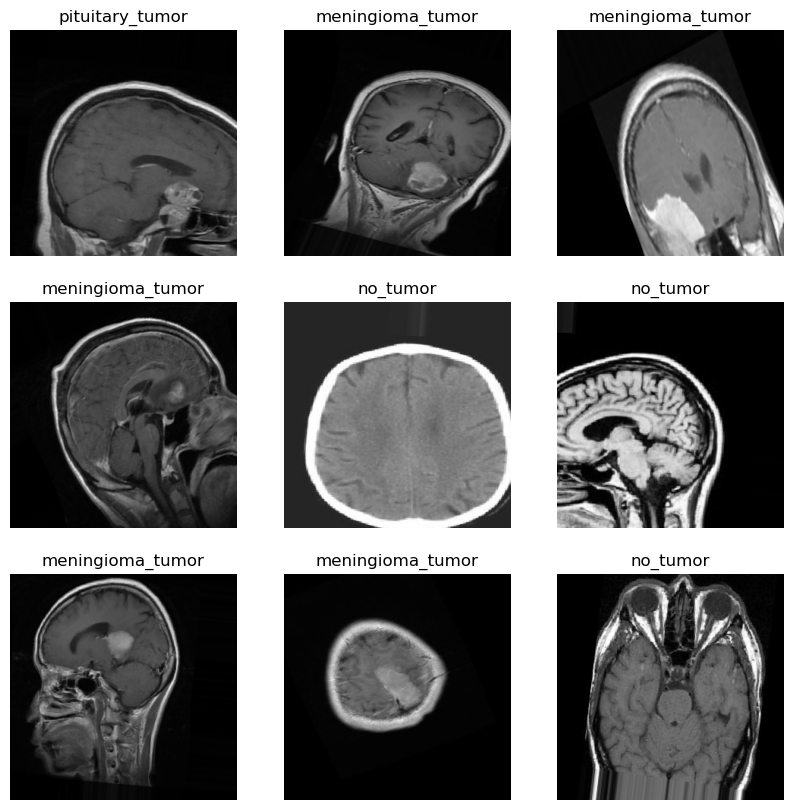

In [6]:
# Get one batch of images and labels
images, labels = next(train_data)  # Get the first batch of images

# Create a figure to display the images
plt.figure(figsize=(10, 10))

# Visualize the first 9 images
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')  # Use 'squeeze()' for grayscale images
    class_index = np.argmax(labels[i])  # Get the index of the predicted class
    plt.title(list(train_data.class_indices.keys())[class_index])  # Get the class name
    plt.axis("off")

plt.show()

In [7]:
# Load the Xception model without the top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


In [8]:
# Freeze all layers except the last 4 for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [9]:
# Build the full model
model = Sequential([
    base_model,               # Xception as the feature extractor
    Flatten(),                # Flattening the output of Xception
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),             # Dropout to prevent overfitting
    Dense(4, activation='softmax')  # Output layer for 4 brain tumor classes
])

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Model summary to verify the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      52,429,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,291,564 (279.59 MB)

 Trainable params: 55,593,732 (212.07 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

In [12]:
from keras.callbacks import EarlyStopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (you can change to 'val_accuracy')
    patience=3,            # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best model's weights after stopping
)


In [13]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,
    callbacks=[early_stopping]
)

C:\Users\kenne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.5663 - loss: 1.0063 - val_accuracy: 0.5660 - val_loss: 1.1253
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.7931 - loss: 0.5468 - val_accuracy: 0.5888 - val_loss: 1.2360
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.8122 - loss: 0.4733 - val_accuracy: 0.6168 - val_loss: 1.1770
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.8256 - loss: 0.4477 - val_accuracy: 0.6218 - val_loss: 1.1846


In [15]:
history_df = pd.DataFrame(history.history)

history_df.to_csv('training_base.csv', index=False)

history_df

,accuracy,loss,val_accuracy,val_loss
0,0.667247,0.812975,0.565990,1.125323
1,0.789895,0.546974,0.588832,1.236016
2,0.817422,0.473733,0.616751,1.177023
3,0.828223,0.447846,0.621827,1.184597


In [14]:
test_loss, test_accuracy = model.evaluate(test_data)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5705 - loss: 1.0877
Test Accuracy: 0.5660
Test Loss: 1.1253


In [28]:
model.save('cnn_model_xception_base.h5')

### Optimisation 1

Model is same but choosing a learning rate. 
Learning rate controls how much the model's parameters (weights and biases) are adjusted with respect to the loss gradient during each iteration of training.
Made trials to identify best starting learning rate.

Found learning rate 1e-4 was best for now.

Test Accuracy: 0.5964
Test Loss: 1.2496

In [18]:
import keras_tuner as kt

In [19]:
def build_model(hp):
    # Load the Xception base model (without the top layers)
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False  # Freeze all layers of the base model
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')  # Output layer for 4 classes
    ])
    
    # Choose a learning rate from 1e-2, 1e-3, and 1e-4
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Instantiate the tuner with RandomSearch or Hyperband
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=5,              # Number of hyperparameter configurations to try
    executions_per_trial=1,    # Number of models to train per trial
    directory='my_dir',
    project_name='learning_rate_tuning'
)

In [20]:
# Run the tuner
tuner.search(train_data, validation_data=test_data, epochs=30, callbacks=[early_stopping])

Trial 3 Complete [00h 11m 26s]
val_accuracy: 0.510152280330658

Best val_accuracy So Far: 0.596446692943573
Total elapsed time: 00h 35m 10s


In [21]:
# Get the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(test_data)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

C:\Users\kenne\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6005 - loss: 1.2749
Test Accuracy: 0.5964
Test Loss: 1.2496


In [22]:
# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hyperparameters.values}")

# Iterate through all trials to get details of each trial's results
for trial in tuner.oracle.get_best_trials(num_trials=5):
    print(f"Trial: {trial.trial_id}, Accuracy: {trial.metrics.get_last_value('accuracy')}, Val Accuracy: {trial.metrics.get_last_value('val_accuracy')}")

Best Hyperparameters: {'learning_rate': 0.0001}
Trial: 0, Accuracy: 0.7815331220626831, Val Accuracy: 0.596446692943573
Trial: 2, Accuracy: 0.6585366129875183, Val Accuracy: 0.510152280330658
Trial: 1, Accuracy: 0.4404181241989136, Val Accuracy: 0.4111675024032593


In [23]:
# Get all the completed trials and print their results
for trial in tuner.oracle.trials.values():
    print(f"Trial {trial.trial_id} completed")
    print(f"  Hyperparameters: {trial.hyperparameters.values}")
    print(f"  Final accuracy: {trial.metrics.get_last_value('accuracy')}")
    print(f"  Final validation accuracy: {trial.metrics.get_last_value('val_accuracy')}")
    print(f"  Final validation loss: {trial.metrics.get_last_value('val_loss')}")

Trial 0 completed
  Hyperparameters: {'learning_rate': 0.0001}
  Final accuracy: 0.7815331220626831
  Final validation accuracy: 0.596446692943573
  Final validation loss: 1.249576449394226
Trial 1 completed
  Hyperparameters: {'learning_rate': 0.01}
  Final accuracy: 0.4404181241989136
  Final validation accuracy: 0.4111675024032593
  Final validation loss: 1.454289197921753
Trial 2 completed
  Hyperparameters: {'learning_rate': 0.001}
  Final accuracy: 0.6585366129875183
  Final validation accuracy: 0.510152280330658
  Final validation loss: 1.185877799987793


In [31]:
# Create a list to store the results
results = []

# Iterate over all the completed trials
for trial in tuner.oracle.trials.values():
    trial_data = {
        'Trial ID': trial.trial_id,
        'Learning Rate': trial.hyperparameters.values['learning_rate'],
        'Final Accuracy': trial.metrics.get_last_value('accuracy'),
        'Final Validation Accuracy': trial.metrics.get_last_value('val_accuracy'),
        'Final Validation Loss': trial.metrics.get_last_value('val_loss')
    }
    results.append(trial_data)

# Convert the list of trial results to a DataFrame
df_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df_results.to_csv('tuning_results.csv', index=False)

# Display the DataFrame to verify
df_results

,Trial ID,Learning Rate,Final Accuracy,Final Validation Accuracy,Final Validation Loss
0,0,0.0001,0.781533,0.596447,1.249576
1,1,0.0100,0.440418,0.411168,1.454289
2,2,0.0010,0.658537,0.510152,1.185878


In [32]:
model.save('cnn_model_xception_opti1.h5')

### Optimisation 2

Tried with unfreezing last 10 layers layers for fine-tuning.

slight increase in accuracy but loss is still high.

accuracy: 0.6323 - loss: 1.0968
Test Accuracy after fine-tuning: 0.6294
Test Loss after fine-tuning: 1.1618

In [36]:
from keras.models import load_model

# Get the best model from the tuner
best_model = load_model('cnn_model_xception_opti1.h5')

# Fine-tune the last 10 layers of Xception (for example)
base_model = best_model.layers[0]  # The Xception base model is the first layer
for layer in base_model.layers[-10:]:
    layer.trainable = True  # Unfreeze the last 10 layers for fine-tuning

# Recompile the model with a smaller learning rate for fine-tuning
best_model.compile(optimizer=Adam(learning_rate=1e-5),  # Use a small learning rate for fine-tuning
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [37]:
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (you can change to 'val_accuracy')
    patience=5,            # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best model's weights after stopping
)

In [38]:
# Fine-tune the model (using a lower learning rate)
history_finetune = best_model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,  # Fine-tune for a few more epochs
    callbacks=[early_stopping]
)

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.6893 - loss: 0.7467 - val_accuracy: 0.5914 - val_loss: 1.2289
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.7781 - loss: 0.5572 - val_accuracy: 0.5787 - val_loss: 1.2558
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.7983 - loss: 0.5236 - val_accuracy: 0.6117 - val_loss: 1.1668
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.8058 - loss: 0.4902 - val_accuracy: 0.6294 - val_loss: 1.1618
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.8406 - loss: 0.4071 - val_accuracy: 0.6421 - val_loss: 1.2946
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.8514 - loss: 0.4043 - val_accuracy: 0.6523 - val_loss: 1.1656
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.8587 - loss: 0.3636 - val_accuracy: 0.6396 - val_loss: 1.2134
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.8660 - loss: 0.3618 - val_accuracy: 0.6497 - v

In [39]:
history_finetune_df = pd.DataFrame(history_finetune.history)

history_finetune_df.to_csv('training_opti1.csv', index=False)

history_finetune_df

,accuracy,loss,val_accuracy,val_loss
0,0.716028,0.685694,0.591371,1.228927
1,0.781185,0.558328,0.578680,1.255828
2,0.802787,0.512796,0.611675,1.166810
3,0.821951,0.458679,0.629442,1.161768
4,0.837282,0.418265,0.642132,1.294623
5,0.856098,0.392635,0.652284,1.165583
6,0.861324,0.361706,0.639594,1.213442
7,0.867596,0.341171,0.649746,1.285626
8,0.884321,0.318513,0.682741,1.199107


In [40]:
# Evaluate the fine-tuned model on the test data
test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Accuracy after fine-tuning: {test_accuracy:.4f}")
print(f"Test Loss after fine-tuning: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6323 - loss: 1.0968
Test Accuracy after fine-tuning: 0.6294
Test Loss after fine-tuning: 1.1618


In [41]:
model.save('cnn_model_xception_opti2.h5')

### Optimisation 3

Trying with unfreezing less layers to  counter overfitting.

Decreased dropout rate to 0.4

lowered the learning rate for more fine-tuning

Decreased epochs to 20 from 30 and increased batch size from 32 to 42

accuracy: 0.5155 - loss: 1.1497
Test Accuracy after fine-tuning: 0.5102
Test Loss after fine-tuning: 1.178
4

In [100]:
# Load the previously saved model
best_model = load_model('cnn_model_xception_opti1.h5')

In [101]:
# Fine-tune the last 4 layers of Xception (for example)
base_model = best_model.layers[0]  # The Xception base model is the first layer
for layer in base_model.layers[-4:]:
    layer.trainable = True  # Unfreeze the last 4 layers for fine-tuning

In [102]:
from keras.layers import BatchNormalization
from keras.regularizers import l2

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),  # Decreased Dropout rate
    Dense(4, activation='softmax')  # Output layer for your 4 classes
])

# Recompile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-7),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [103]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │      52,429,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,291,564 (279.59 MB)

 Trainable params: 55,593,732 (212.07 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

In [104]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best model's weights after stopping
)

In [105]:
# Fine-tune the model using the adjusted architecture and data augmentation
history_finetune = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,  # Fine-tune for a few more epochs
    batch_size=41,  # Experiment with different batch sizes
    callbacks=[early_stopping]
)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.2214 - loss: 1.5643 - val_accuracy: 0.3173 - val_loss: 1.3508
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.3042 - loss: 1.4375 - val_accuracy: 0.3503 - val_loss: 1.3174
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.3583 - loss: 1.3490 - val_accuracy: 0.3553 - val_loss: 1.2877
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.4175 - loss: 1.2774 - val_accuracy: 0.4061 - val_loss: 1.2589
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.4558 - loss: 1.2133 - val_accuracy: 0.4289 - val_loss: 1.2354
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.4963 - loss: 1.1491 - val_accuracy: 0.4518 - val_loss: 1.2178
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.5348 - loss: 1.0926 - val_accuracy: 0.4619 - val_loss: 1.2035
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.5542 - loss: 1.0495 - val_accuracy: 0.4746 - v

In [106]:
history_finetune_df = pd.DataFrame(history_finetune.history)

history_finetune_df.to_csv('training_opti3.csv', index=False)

history_finetune_df

,accuracy,loss,val_accuracy,val_loss
0,0.255401,1.513321,0.317259,1.350791
1,0.320906,1.405230,0.350254,1.317411
2,0.380488,1.316474,0.355330,1.287745
3,0.426132,1.248990,0.406091,1.258868
4,0.471080,1.189151,0.428934,1.235446
5,0.493728,1.138967,0.451777,1.217835
6,0.537979,1.080273,0.461929,1.203459
7,0.551916,1.049249,0.474619,1.193737
8,0.583624,1.013485,0.479695,1.188955
9,0.595122,0.986417,0.489848,1.181163


In [107]:
# Evaluate the fine-tuned model on the test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy after fine-tuning: {test_accuracy:.4f}")
print(f"Test Loss after fine-tuning: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5155 - loss: 1.1497
Test Accuracy after fine-tuning: 0.5102
Test Loss after fine-tuning: 1.1788


In [109]:
model.save('cnn_model_xception_opti3.h5')

RuntimeError: Can't decrement id ref count (unable to extend file properly)

### Optimisation 4

Started with all frozen layers and then train only the dense layers to let them adjust first

Added batch normalisation

Use Learning Rate schedulers -  ReduceLROnPlateau callback

Batch size back to 32

Reduced dropout to 0.3

Used learning rate 1e-5

accuracy: 0.6496 - loss: 1.5244

Test Accuracy after fine-tuning: 0.670
1
Test Loss after fine-tuning: 1.33

Accuracy improved but val_loss higher72

In [79]:
# Load the previously saved model
best_model = load_model('cnn_model_xception_opti3.h5')

In [75]:
# Keep all layers frozen initially
for layer in model.layers:
    layer.trainable = False

In [80]:
# Modify model architecture
model = Sequential([
    model.layers[0],
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

# Compile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
from keras.callbacks import ReduceLROnPlateau
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1)

In [83]:
# Fine-tune with adjusted batch size and callbacks
history_opti4 = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5,
    batch_size=32,  # Experiment with larger batch size
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.5964 - loss: 1.2044 - val_accuracy: 0.5355 - val_loss: 1.4582 - learning_rate: 1.0000e-05
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.7651 - loss: 0.6821 - val_accuracy: 0.6421 - val_loss: 1.4522 - learning_rate: 1.0000e-05
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.8175 - loss: 0.5314 - val_accuracy: 0.6396 - val_loss: 1.4261 - learning_rate: 1.0000e-05
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.8374 - loss: 0.4741 - val_accuracy: 0.6244 - val_loss: 1.6702 - learning_rate: 1.0000e-05
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.8577 - loss: 0.4141 - val_accuracy: 0.6371 - val_loss: 1.5496 - learning_rate: 1.0000e-05


In [85]:
history_opti4v1_df = pd.DataFrame(history_opti4.history)

history_opti4v1_df.to_csv('training_opti4.1.csv', index=False)

history_opti4v1_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.692334,0.929300,0.535533,1.458208,0.00001
1,0.782230,0.632575,0.642132,1.452216,0.00001
2,0.817422,0.527764,0.639594,1.426125,0.00001
3,0.837631,0.466249,0.624366,1.670183,0.00001
4,0.857840,0.409936,0.637056,1.549601,0.00001


In [86]:
# Unfreeze only the last few layers for fine-tuning
for layer in model.layers[0].layers[-3:]:  # Unfreeze only last 3 layers
    layer.trainable = True

# Recompile the model for fine-tuning with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
# Fine-tune the model
history_finetune2 = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,  # Fine-tuning epochs
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.8313 - loss: 0.4492 - val_accuracy: 0.6523 - val_loss: 1.3590 - learning_rate: 1.0000e-06
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.8344 - loss: 0.4580 - val_accuracy: 0.6548 - val_loss: 1.3445 - learning_rate: 1.0000e-06
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.8676 - loss: 0.3829 - val_accuracy: 0.6523 - val_loss: 1.4305 - learning_rate: 1.0000e-06
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.8585 - loss: 0.3834 - val_accuracy: 0.6701 - val_loss: 1.3372 - learning_rate: 1.0000e-06
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.8522 - loss: 0.4115 - val_accuracy: 0.6827 - val_loss: 1.4444 - learning_rate: 1.0000e-06
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.8799 - loss: 0.3465 - val_accuracy: 0.6853 - val_loss: 1.3811 - learning_rate: 1.0000e-06
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8623 - 

In [88]:
history_opti4v2_df = pd.DataFrame(history_finetune2.history)

history_opti4v2_df.to_csv('training_opti4.2.csv', index=False)

history_opti4v2_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.841812,0.434720,0.652284,1.359034,1.000000e-06
1,0.847038,0.417656,0.654822,1.344462,1.000000e-06
2,0.862021,0.396729,0.652284,1.430454,1.000000e-06
3,0.862021,0.390410,0.670051,1.337225,1.000000e-06
4,0.861672,0.390088,0.682741,1.444417,1.000000e-06
5,0.872822,0.366779,0.685279,1.381137,1.000000e-06
6,0.870035,0.376009,0.682741,1.418422,1.000000e-06
7,0.881533,0.352714,0.687817,1.380392,5.000000e-07
8,0.871777,0.366190,0.705584,1.351339,5.000000e-07


In [89]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy after fine-tuning: {test_accuracy:.4f}")
print(f"Test Loss after fine-tuning: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6496 - loss: 1.5244
Test Accuracy after fine-tuning: 0.6701
Test Loss after fine-tuning: 1.3372


In [90]:
model.save('cnn_model_xception_opti4.h5')

### Optimisation 5

Increased dropout to 0.4

Increase learning rate to 1e-6

Unfreeze last 3 layers

accuracy: 0.6267 - loss: 1.1812
Test Accuracy after fine-tuning: 0.5787
Test Loss after fine-tuning: 1.30

Lower accuracy and lower loss but still not good09

In [92]:
# Load the previously saved model
best_model = load_model('cnn_model_xception_opti4.h5')

In [93]:
# Keep all layers frozen initially and unfreeze gradually
for layer in model.layers:
    layer.trainable = False

In [94]:
# Rebuild the model with a slight increase in dropout
model = Sequential([
    model.layers[0],  # Base model
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Slightly increased dropout rate for regularization
    Dense(4, activation='softmax')
])

# Compile with a learning rate that can be adjusted with ReduceLROnPlateau
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [95]:
# Train the model with all layers frozen initially
history_initial2 = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.5866 - loss: 1.2977 - val_accuracy: 0.5711 - val_loss: 1.1894 - learning_rate: 1.0000e-05
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.7790 - loss: 0.7046 - val_accuracy: 0.6294 - val_loss: 1.3646 - learning_rate: 1.0000e-05
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.7928 - loss: 0.5816 - val_accuracy: 0.6421 - val_loss: 1.5162 - learning_rate: 1.0000e-05
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8351 - loss: 0.4797
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
90/90 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8352 - loss: 0.4797 - val_accuracy: 0.6548 - val_loss: 1.5657 - learning_rate: 1.0000e-05
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8466 - loss: 0.4132 - val_accuracy: 0.6802 - val_loss: 1.2852 - learning_rate: 5.0000e-06


In [96]:
# Unfreeze only the last 3 layers for fine-tuning
for layer in model.layers[0].layers[-3:]:
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
# Fine-tune the model with the adjusted data augmentation and batch size
history_opti5 = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.7778 - loss: 0.6800 - val_accuracy: 0.5787 - val_loss: 1.3009 - learning_rate: 1.0000e-06
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.7869 - loss: 0.6245 - val_accuracy: 0.5838 - val_loss: 1.4150 - learning_rate: 1.0000e-06
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.7859 - loss: 0.6080 - val_accuracy: 0.5736 - val_loss: 1.4541 - learning_rate: 1.0000e-06
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8029 - loss: 0.5899
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
90/90 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.8029 - loss: 0.5896 - val_accuracy: 0.5964 - val_loss: 1.4717 - learning_rate: 1.0000e-06
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.8241 - loss: 0.5367 - val_accuracy: 0.5964 - val_loss: 1.5143 - learning_rate: 5.0000e-07


In [98]:
history_opti5_df = pd.DataFrame(history_opti5.history)

history_opti5_df.to_csv('training_opti5.csv', index=False)

history_opti5_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.770732,0.671734,0.578680,1.300854,1.000000e-06
1,0.793031,0.602595,0.583756,1.414997,1.000000e-06
2,0.801394,0.581502,0.573604,1.454103,1.000000e-06
3,0.806272,0.562355,0.596447,1.471690,1.000000e-06
4,0.819164,0.537100,0.596447,1.514294,5.000000e-07


In [99]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy after fine-tuning: {test_accuracy:.4f}")
print(f"Test Loss after fine-tuning: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6267 - loss: 1.1812
Test Accuracy after fine-tuning: 0.5787
Test Loss after fine-tuning: 1.3009


In [110]:
# Save the fine-tuned model
model.save('cnn_model_xception_opti5.h5')

RuntimeError: Can't decrement id ref count (unable to extend file properly)

In [112]:
from sklearn.metrics import confusion_matrix, classification_report

# 2. Confusion Matrix and Classification Report
# Generate predictions
y_pred = model.predict(test_data)  # Replace 'test_data' with your test data object
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes  # True labels from the test dataset

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


In [113]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys()))

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.31      0.16      0.21       100
meningioma_tumor       0.29      0.28      0.28       115
        no_tumor       0.28      0.30      0.29       105
 pituitary_tumor       0.28      0.46      0.35        74

        accuracy                           0.29       394
       macro avg       0.29      0.30      0.28       394
    weighted avg       0.29      0.29      0.28       394

